<a href="https://colab.research.google.com/github/SoheilBadri2000/DataScience2/blob/main/34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siamese Networks

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Define Transformers
my_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# Load the Siamese-Triplet MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=my_transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=my_transform)

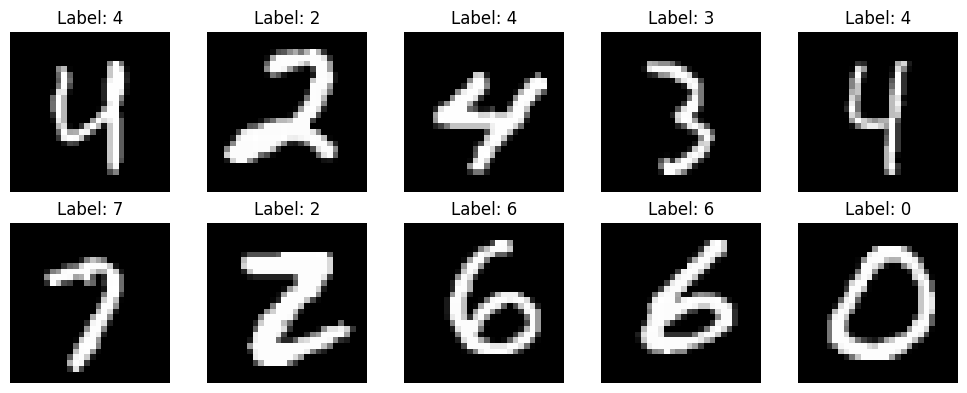

In [7]:
# Show some examples from the MNIST dataset
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10,4))
for i in range(2):
  for j in range(5):
    idx = np.random.randint(len(train_dataset))
    img, label = train_dataset[idx]
    axs[i, j].imshow(img.squeeze(), cmap='gray')
    axs[i, j].set_title(f'Label: {label}')
    axs[i, j].axis('off')
plt.tight_layout()
plt.show()

In [11]:
def create_triplets(dataset):
  """
  Create triplets of images from a given dataset.

  Args:
    dataset: PyTorch dataset object

  Returns:
    triplets: List of triplets, where each triplet is a tuple of three tensors (anchor, positive, negative)
    and each element in the tuple is a PyTorch tensor of shape (1, 28, 28).
  """

  triplets = []
  for i in range(len(dataset)):

    # Select anchor image
    anchor_img, anchor_label = dataset[i]
    anchor_img = torch.from_numpy(anchor_img.numpy())

    # Select positive image with the same label as the anchor image
    positive_indices = np.where(dataset.targets == anchor_label)[0]
    positive_index = np.random.choice(positive_indices)
    positive_img, _ = dataset[positive_index]
    positive_img = torch.from_numpy(positive_img.numpy())

    # Select negative image with a different label from the anchor image
    negative_indices = np.where(dataset.targets != anchor_label)[0]
    negative_index = np.random.choice(negative_indices)
    negative_img, _ = dataset[negative_index]
    negative_img = torch.from_numpy(negative_img.numpy())

    triplets.append((anchor_img, positive_img, negative_img))

  return triplets

In [12]:
# Create Siamese triplets from the training dataset
train_triplets = create_triplets(train_dataset)
# Create Siamese triplets from the test dataset
test_triplets = create_triplets(test_dataset)

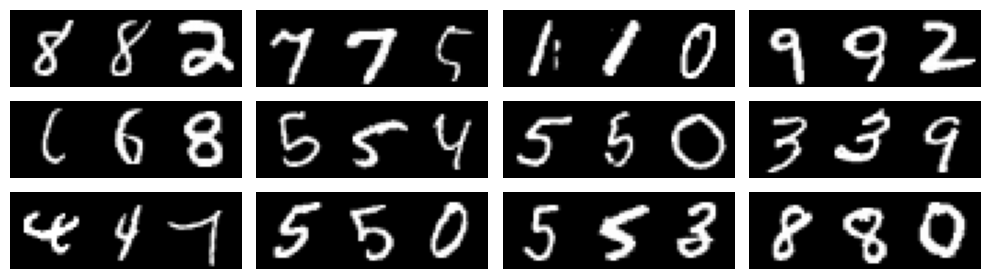

In [13]:
# Display some random triplets
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10,3))
for i in range(3):
  for j in range(4):
    anchor, positive, negative = train_triplets[np.random.randint(len(train_triplets))]
    axs[i, j].imshow(torch.cat((anchor, positive, negative), dim=2).squeeze(), cmap='gray')
    axs[i, j].axis('off')
plt.tight_layout()
plt.show()

In [14]:
# Define a function to create a DataLoader for the triplets
def create_dataloader(triplets, batch_size):
  """
  Create a DataLoader for the given triplets.
  """
  dataset = torch.utils.data.TensorDataset(*[torch.stack(t) for t in zip(*triplets)])
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
  return dataloader

In [15]:
# Create a DataLoader for the triplets
batch_size = 28
num_epochs = 2
train_dataloader = create_dataloader(train_triplets, batch_size)
test_dataloader = create_dataloader(test_triplets, batch_size)

In [16]:
class SiameseNet(nn.Module):
  def __init__(self):
    super(SiameseNet, self).__init__()

    # Convolutional Layers
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(64 * 7 * 7, 256)
    self.fc2 = nn.Linear(256, 2)

  def forward(self, x1, x2):
    # Forward pass for the first input
    out1 = self.conv1(x1)
    out1 = torch.nn.functional.relu(out1)
    out1 = torch.nn.functional.max_pool2d(out1, kernel_size=2)
    out1 = self.conv2(out1)
    out1 = torch.nn.functional.relu(out1)
    out1 = torch.nn.functional.max_pool2d(out1, kernel_size=2)
    out1 = out1.view(out1.size(0), -1)
    out1 = self.fc1(out1)
    out1 = torch.nn.functional.relu(out1)
    out1 = self.fc2(out1)

    # Forward pass for the second input
    out2 = self.conv1(x2)
    out2 = torch.nn.functional.relu(out2)
    out2 = torch.nn.functional.max_pool2d(out2, kernel_size=2)
    out2 = self.conv2(out2)
    out2 = torch.nn.functional.relu(out2)
    out2 = torch.nn.functional.max_pool2d(out2, kernel_size=2)
    out2 = out2.view(out2.size(0), -1)
    out2 = self.fc1(out2)
    out2 = torch.nn.functional.relu(out2)
    out2 = self.fc2(out2)

    return out1, out2

In [17]:
def test_model(model, test_dataloader):
  """
  Evaluate the model on the test set and return the accuracy.
  """
  # Set the model to evaluation mode
  model.eval()
  # Keep track of the number of correct predictions
  num_correct = 0
  # Iterate over the test set
  for batch_idx, batch in enumerate(test_dataloader):
    # Extract the anchor, positive, and negative images from the batch
    anchor_imgs, positive_imgs, negative_imgs = batch
    # Forward pass through the model
    anchor_out, positive_out = model(anchor_imgs, positive_imgs)
    anchor_out, negative_out = model(anchor_imgs, negative_imgs)
    # Calculate the distances between the anchor and positive/negative embeddings
    pos_dist = F.pairwise_distance(anchor_out, positive_out)
    neg_dist = F.pairwise_distance(anchor_out, negative_out)
    # Compute the binary classification Labels (1 if positive pair, 0 if negative pair)
    labels = (pos_dist < neg_dist).float()
    # Count the number of correct predictions
    num_correct += torch.sum(labels).item()
  # Compute the accuracy
  accuracy = num_correct / len(test_dataloader.dataset)
  # Print the accuracy
  print(f'Accuracy: {accuracy:.4f}')
  return accuracy

In [19]:
# Instantiate the model and define the optimizer
model = SiameseNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the Loss function
criterion = nn.TripletMarginLoss(margin=1.0)

# Set the model to train mode
model.train()

# Train the model
for epoch in range(num_epochs):
  for batch_idx, batch in enumerate(train_dataloader):
    # Zero the gradients
    optimizer.zero_grad()
    # Extract the anchor, positive, and negative images from the batch
    anchor_imgs, positive_imgs, negative_imgs = batch
    # Forward pass through the model
    anchor_out, positive_out = model(anchor_imgs, positive_imgs)
    anchor_out, negative_out = model(anchor_imgs, negative_imgs)
    # Calculate the loss
    loss = criterion(anchor_out, positive_out, negative_out)
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    # Print progress
    if batch_idx % 100 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}')

  # Test the model on the test set
  test_model(model, test_dataloader)

Epoch 1/2, Batch 1/2143, Loss: 0.9951
Epoch 1/2, Batch 101/2143, Loss: 0.4263
Epoch 1/2, Batch 201/2143, Loss: 0.2870
Epoch 1/2, Batch 301/2143, Loss: 0.2714
Epoch 1/2, Batch 401/2143, Loss: 0.1439
Epoch 1/2, Batch 501/2143, Loss: 0.0016
Epoch 1/2, Batch 601/2143, Loss: 0.1324
Epoch 1/2, Batch 701/2143, Loss: 0.0741
Epoch 1/2, Batch 801/2143, Loss: 0.2978
Epoch 1/2, Batch 901/2143, Loss: 0.0547
Epoch 1/2, Batch 1001/2143, Loss: 0.0592
Epoch 1/2, Batch 1101/2143, Loss: 0.1462
Epoch 1/2, Batch 1201/2143, Loss: 0.0000
Epoch 1/2, Batch 1301/2143, Loss: 0.0252
Epoch 1/2, Batch 1401/2143, Loss: 0.1041
Epoch 1/2, Batch 1501/2143, Loss: 0.0892
Epoch 1/2, Batch 1601/2143, Loss: 0.0727
Epoch 1/2, Batch 1701/2143, Loss: 0.0237
Epoch 1/2, Batch 1801/2143, Loss: 0.0324
Epoch 1/2, Batch 1901/2143, Loss: 0.0000
Epoch 1/2, Batch 2001/2143, Loss: 0.0201
Epoch 1/2, Batch 2101/2143, Loss: 0.1526
Accuracy: 0.9802
Epoch 2/2, Batch 1/2143, Loss: 0.1866
Epoch 2/2, Batch 101/2143, Loss: 0.0761
Epoch 2/2, Batc

In [23]:
def plot_test_triplets(model, dataloader, num_triplets=5):
  # Select a random subset of triplets from the test set
  triplet = iter(dataloader)
  triplets = next(triplet)
  anchor_imgs, positive_imgs, negative_imgs = triplets

  # Make predictions on each triplet and plot the results
  for idx in range(num_triplets):
    anchor_img, positive_img, negative_img = anchor_imgs[idx], positive_imgs[idx], negative_imgs[idx]

    # Make predictions on the anchor, positive and negative images
    anchor_img_tens = torch.tensor(anchor_img.unsqueeze(0))
    positive_img_tens = torch.tensor(positive_img.unsqueeze(0))
    negative_img_tens = torch.tensor(negative_img.unsqueeze(0))
    anchor_pred, _ = model(anchor_img_tens, anchor_img_tens)
    positive_pred, _ = model(positive_img_tens, positive_img_tens)
    negative_pred, _ = model(negative_img_tens, negative_img_tens)

    # Select the embeddings from the tuples and convert them into tensors
    anchor_pred = anchor_pred.squeeze()
    positive_pred = positive_pred.squeeze()
    negative_pred = negative_pred.squeeze()

    # Compute the distances between the embeddings
    pos_dist = F.pairwise_distance(anchor_pred, positive_pred)
    neg_dist = F.pairwise_distance(anchor_pred, negative_pred)

    # Plot the triplets and their predictions
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    ax1.imshow(anchor_img.permute(1, 2, 0))
    ax1.set_title('Anchor')
    ax2.imshow(positive_img.permute(1, 2, 0))
    ax2.set_title('Positive')
    ax3.imshow(negative_img.permute(1, 2, 0))
    ax3.set_title('Negative')
    fig.suptitle(f'Distance: {pos_dist.item():.2f} vs {neg_dist.item():.2f}')
    plt.show()

<ipython-input-23-3e1e48e50ab9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  anchor_img_tens = torch.tensor(anchor_img.unsqueeze(0))
<ipython-input-23-3e1e48e50ab9>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_img_tens = torch.tensor(positive_img.unsqueeze(0))
<ipython-input-23-3e1e48e50ab9>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  negative_img_tens = torch.tensor(negative_img.unsqueeze(0))


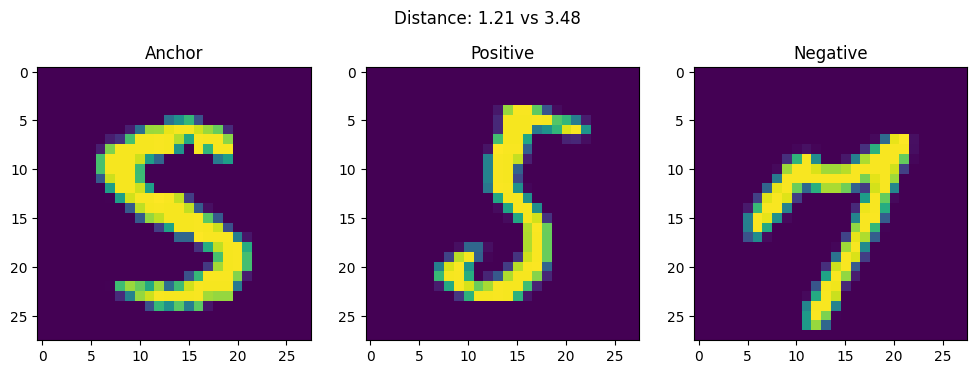

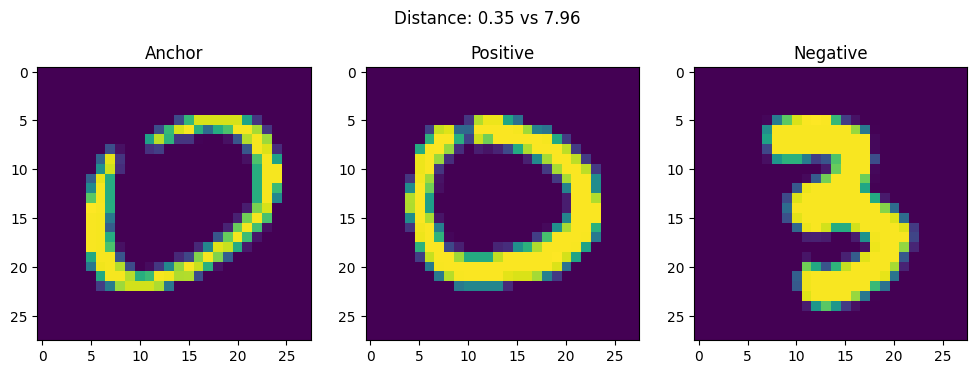

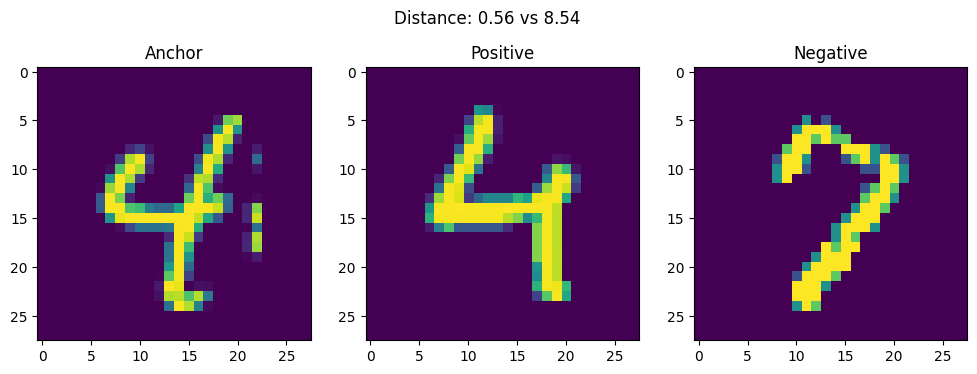

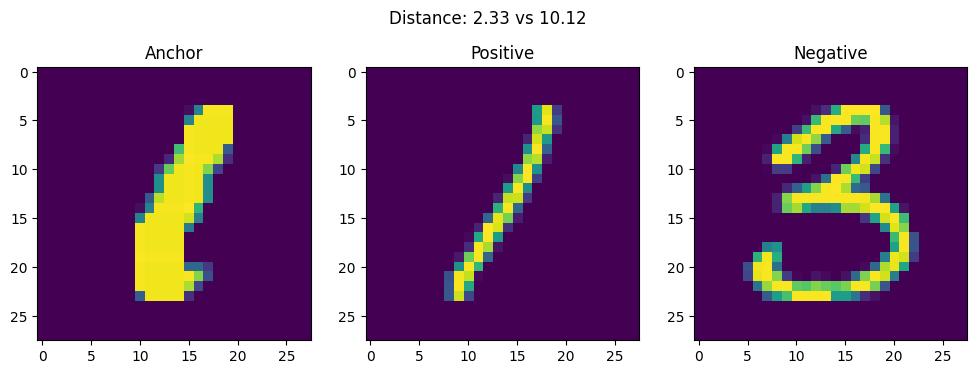

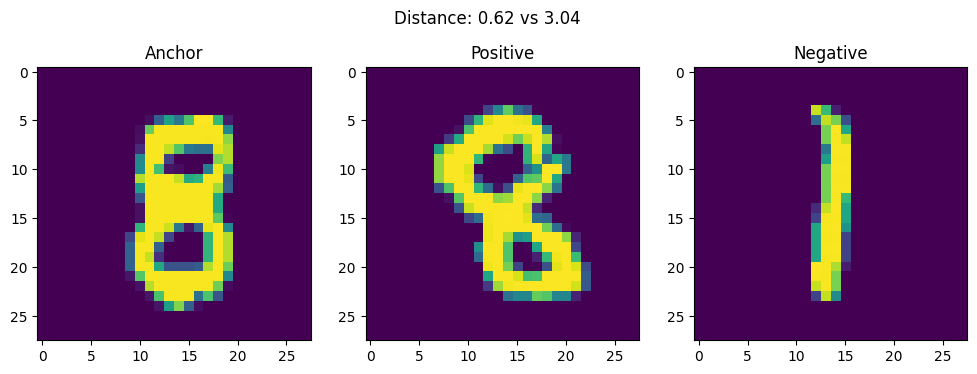

In [24]:
# Plot test triplets with their distance values as labels
plot_test_triplets(model, test_dataloader)